In [1]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from pandas.plotting import lag_plot
from pandas.tools.plotting import autocorrelation_plot

import pickle
import quandl
from datetime import datetime


import math
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.tsa.stattools as ts




import statsmodels.api as sm

import scipy.stats as ss

import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)

from quandl.errors.quandl_error import NotFoundError



import sklearn as sk
from sklearn import preprocessing as pr
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

import matplotlib.patches as mpatches
from scipy.signal import correlate
from scipy.stats.mstats import spearmanr
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.graphics.tsaplots import plot_pacf

import seaborn as sns
from datetime import datetime, timedelta

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from scipy import stats
import statsmodels.api as sm
from itertools import product

import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

import itertools
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'

#import matplotlib.pyplot as plt
#import numpy as np
#import pandas as pd

In [2]:
'''Retrieve Bitcoin Pricing data using Quandl'''

def get_quandl_data(quandl_id):
    '''Download and cache Quandl dataseries'''
    cache_path = '{}.pkl'.format(quandl_id).replace('/','-')
    try:
        f = open(cache_path, 'rb')
        df = pickle.load(f)   
        print('Loaded {} from cache'.format(quandl_id))
    except (OSError, IOError) as e:
        print('Downloading {} from Quandl'.format(quandl_id))
        df = quandl.get(quandl_id, returns="pandas")
        df.to_pickle(cache_path)
        print('Cached {} at {}'.format(quandl_id, cache_path))
    return df

In [3]:
'''Pull kraken exchange pricing data'''

quandl_api_key = "sWmNm41Ji9goVFUtnUxe"
quandl.ApiConfig.api_key = quandl_api_key
btc_usd_price_kraken = get_quandl_data('BCHARTS/KRAKENUSD')

Loaded BCHARTS/KRAKENUSD from cache


In [4]:
btc_usd_price_kraken.head()

Open       High        Low      Close  Volume (BTC)  \
Date                                                                   
2014-01-07  874.67040  892.06753  810.00000  810.00000     15.622378   
2014-01-08  810.00000  899.84281  788.00000  824.98287     19.182756   
2014-01-09  825.56345  870.00000  807.42084  841.86934      8.158335   
2014-01-10  839.99000  857.34056  817.00000  857.33056      8.024510   
2014-01-11  858.20000  918.05471  857.16554  899.84105     18.748285   

            Volume (Currency)  Weighted Price  
Date                                           
2014-01-07       13151.472844      841.835522  
2014-01-08       16097.329584      839.156269  
2014-01-09        6784.249982      831.572913  
2014-01-10        6780.220188      844.938794  
2014-01-11       16698.566929      890.671709

In [5]:
'''Plotting the BTC kraken pricing data'''

btc_trace = go.Scatter(x=btc_usd_price_kraken.index, y=btc_usd_price_kraken['Weighted Price'])
py.iplot([btc_trace])

In [6]:
'''Pull pricing data for 3 more BTC exchanges'''

try:
    exchanges = ['COINBASE','BITSTAMP','ITBIT']

    exchange_data = {}

    exchange_data['KRAKEN'] = btc_usd_price_kraken

    for exchange in exchanges:
        exchange_code = 'BCHARTS/{}USD'.format(exchange)
        btc_exchange_df = get_quandl_data(exchange_code)
        exchange_data[exchange] = btc_exchange_df
    
except NotFoundError as e:
         print('error: {} '.format(str(e)))

Loaded BCHARTS/COINBASEUSD from cache
Loaded BCHARTS/BITSTAMPUSD from cache
Loaded BCHARTS/ITBITUSD from cache


In [7]:
def merge_dfs_on_column(dataframes, labels, col):
    '''Merge a single column of each dataframe into a new combined dataframe'''
    series_dict = {}
    for index in range(len(dataframes)):
        series_dict[labels[index]] = dataframes[index][col]
        
    return pd.DataFrame(series_dict)

In [8]:
'''Merge the BTC price dataseries' into a single dataframe'''
btc_usd_datasets = merge_dfs_on_column(list(exchange_data.values()), list(exchange_data.keys()), 'Weighted Price')

In [9]:
'''Previewing the last 5 rows'''
btc_usd_datasets.tail()

KRAKEN     COINBASE     BITSTAMP        ITBIT
Date                                                          
2018-09-16  6463.753311  6463.503207  6456.389531  6465.736285
2018-09-17  6335.470383  6352.904890  6323.180216  6283.055160
2018-09-18  6306.223215  6306.788616  6305.513155  6307.623402
2018-09-19  6344.751761  6340.783998  6329.133068  6334.001018
2018-09-20  6402.268693  6397.008433  6400.597781  6400.345052

In [10]:
'''The prices look to be as expected: they are in similar ranges, but with slight variations based on the supply and demand of each individual Bitcoin exchange.'''

'''Visualizing the pricing datasets.'''

def df_scatter(df, title, seperate_y_axis=False, y_axis_label='', scale='linear', initial_hide=False):
    '''Generate a scatter plot of the entire dataframe'''
    label_arr = list(df)
    series_arr = list(map(lambda col: df[col], label_arr))
    
    layout = go.Layout(
        title=title,
        legend=dict(orientation="h"),
        xaxis=dict(type='date'),
        yaxis=dict(
            title=y_axis_label,
            showticklabels= not seperate_y_axis,
            type=scale
        )
    )
    
    y_axis_config = dict(
        overlaying='y',
        showticklabels=False,
        type=scale )
    
    visibility = 'visible'
    if initial_hide:
        visibility = 'legendonly'
        
    # Form Trace For Each Series
    trace_arr = []
    for index, series in enumerate(series_arr):
        trace = go.Scatter(
            x=series.index, 
            y=series, 
            name=label_arr[index],
            #visible=visibility
        )
        
        # Add seperate axis for the series
        if seperate_y_axis:
            trace['yaxis'] = 'y{}'.format(index + 1)
            layout['yaxis{}'.format(index + 1)] = y_axis_config    
        trace_arr.append(trace)

    fig = go.Figure(data=trace_arr, layout=layout)
    py.iplot(fig)

In [11]:
df_scatter(btc_usd_datasets, 'Bitcoin Price (USD) By Exchange')

In [12]:
'''Clean and Aggregate the Pricing Data'''

'''Remove all "0" values from dataframe, since BTC price has never been zero.''' 

btc_usd_datasets.replace(0, np.nan, inplace=True)

In [13]:

'''Plot the revised dataframe''' 
df_scatter(btc_usd_datasets, 'Bitcoin Price (USD) By Exchange')

In [14]:
'''Calculate the average BTC price as a new column''' 
btc_usd_datasets['avg_btc_price_usd'] = btc_usd_datasets.mean(axis=1)

In [15]:
'''Plot the average BTC price'''
btc_trace = go.Scatter(x=btc_usd_datasets.index, y=btc_usd_datasets['avg_btc_price_usd'])
py.iplot([btc_trace])

In [16]:
'''Define Poloniex API Helper Functions'''

def get_json_data(json_url, cache_path):
    '''Download and cache JSON data, return as a dataframe.'''
    try:        
        f = open(cache_path, 'rb')
        df = pickle.load(f)   
        print('Loaded {} from cache'.format(json_url))
    except (OSError, IOError) as e:
        print('Downloading {}'.format(json_url))
        df = pd.read_json(json_url)
        df.to_pickle(cache_path)
        print('Cached {} at {}'.format(json_url, cache_path))
    return df

In [17]:
'''Generate Poloniex API HTTP requests. Call get_json_data() to save the results.'''

base_polo_url = 'https://poloniex.com/public?command=returnChartData&currencyPair={}&start={}&end={}&period={}'
start_date = datetime.strptime('2015-01-01', '%Y-%m-%d') # get data from the start of 2015
end_date = datetime.now() # up until today
period = 86400 # pull daily data (86,400 seconds per day)

def get_crypto_data(poloniex_pair):
    '''Retrieve cryptocurrency data from poloniex'''
    json_url = base_polo_url.format(poloniex_pair, start_date.timestamp(), end_date.timestamp(), period)
    data_df = get_json_data(json_url, poloniex_pair)
    data_df = data_df.set_index('date')
    return data_df

In [18]:
'''Download Trading Data From Poloniex'''

'''Downloaded exchange data for the top cryptocurrencies -
Ethereum, Litecoin, Ripple, Ethereum Classic, Stellar, Dash, Siacoin, Monero, NEM, and Zcash'''



altcoins = ['ETH','LTC','XRP','ETC','STR','DASH','SC','XMR','XEM', 'ZEC']

altcoin_data = {}
for altcoin in altcoins:
    coinpair = 'BTC_{}'.format(altcoin)
    crypto_price_df = get_crypto_data(coinpair)
    altcoin_data[altcoin] = crypto_price_df

Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_ETH&start=1420041600.0&end=1541999372.964277&period=86400 from cache
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_LTC&start=1420041600.0&end=1541999372.964277&period=86400 from cache
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_XRP&start=1420041600.0&end=1541999372.964277&period=86400 from cache
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_ETC&start=1420041600.0&end=1541999372.964277&period=86400 from cache
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_STR&start=1420041600.0&end=1541999372.964277&period=86400 from cache
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_DASH&start=1420041600.0&end=1541999372.964277&period=86400 from cache
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_SC&start=1420041600.0&end=1541999372.964277&period=86

In [19]:
altcoin_data['ETH'].tail()

close      high       low      open   quoteVolume       volume  \
date                                                                            
2018-09-17  0.031329  0.034458  0.030883  0.033900  44574.484151  1463.493520   
2018-09-18  0.032906  0.033697  0.031123  0.031381  26166.180830   853.666308   
2018-09-19  0.032812  0.033771  0.032110  0.032946  19260.716295   633.067894   
2018-09-20  0.034564  0.034895  0.032292  0.032805  31772.436400  1059.166417   
2018-09-21  0.033925  0.034702  0.033848  0.034579   5950.765887   203.672572   

            weightedAverage  
date                         
2018-09-17         0.032833  
2018-09-18         0.032625  
2018-09-19         0.032868  
2018-09-20         0.033336  
2018-09-21         0.034226

In [20]:
'''Convert Prices to USD'''

# Calculate USD Price as a new column in each altcoin dataframe
for altcoin in altcoin_data.keys():
    altcoin_data[altcoin]['price_usd'] =  altcoin_data[altcoin]['weightedAverage'] * btc_usd_datasets['avg_btc_price_usd']

In [21]:
# Merge USD price of each altcoin into single dataframe 
combined_df = merge_dfs_on_column(list(altcoin_data.values()), list(altcoin_data.keys()), 'price_usd')

In [22]:
# Add BTC price to the dataframe
combined_df['BTC'] = btc_usd_datasets['avg_btc_price_usd']

In [23]:
# Chart all of the altocoin prices
df_scatter(combined_df, 'Cryptocurrency Prices (USD)', seperate_y_axis=False, y_axis_label='Coin Value (USD)', scale='log')

In [24]:


df1 = pd.read_csv('C:\\Users\\ShiviMalhotra\\Desktop\\research material\\cryptocompare_BTC.csv') 

In [25]:
btc_trace = go.Scatter(x=df1['timeDate'], y=df1['volumefrom'])
py.iplot([btc_trace])

In [26]:
'''correlation hypothesis using the Pandas corr() method, which computes a Pearson correlation coefficient for each column in the dataframe against each other column'''

# Calculate the pearson correlation coefficients for cryptocurrencies in 2016
combined_df_2016 = combined_df[combined_df.index.year == 2016]
combined_df_2016.pct_change().corr(method='pearson')

ETH       LTC       XRP       ETC       STR      DASH        SC  \
ETH   1.000000 -0.064652  0.085630 -0.181991  0.035093  0.122695  0.169642   
LTC  -0.064652  1.000000  0.053712 -0.131079  0.113523 -0.012194  0.012253   
XRP   0.085630  0.053712  1.000000 -0.054095  0.320116  0.088657  0.021098   
ETC  -0.181991 -0.131079 -0.054095  1.000000 -0.102654  0.003992 -0.008066   
STR   0.035093  0.113523  0.320116 -0.102654  1.000000  0.058083  0.143252   
DASH  0.122695 -0.012194  0.088657  0.003992  0.058083  1.000000  0.026602   
SC    0.169642  0.012253  0.021098 -0.008066  0.143252  0.026602  1.000000   
XMR   0.087216  0.129475  0.027649 -0.105898  0.027998  0.121537  0.047910   
XEM   0.043205  0.160667  0.101326 -0.080938  0.225132  0.014571  0.106153   
ZEC   0.112247  0.142880 -0.101774  0.062003 -0.001715  0.040876  0.020958   
BTC  -0.006502  0.750174  0.044161 -0.170538  0.079075 -0.014040  0.035116   

           XMR       XEM       ZEC       BTC  
ETH   0.087216  0.043205  0.112247 -0.006502  
LTC   0.129475  0.160667  0.142880  0.750174  
XRP   0.027649  0.101326 -0.101774  0.044161  
ETC  -0.105898 -0.080938  0.062003 -0.170538  
STR   0.027998  0.225132 -0.001715  0.079075  
DASH  0.121537  0.014571  0.040876 -0.014040  
SC    0.047910  0.106153  0.020958  0.035116  
XMR   1.000000  0.016438  0.106825  0.127520  
XEM   0.016438  1.000000 -0.033197  0.227674  
ZEC   0.106825 -0.033197  1.000000  0.199881  
BTC   0.127520  0.227674  0.199881  1.000000

In [27]:
'''To help visualize these results, we'll create one more helper visualization function.'''

def correlation_heatmap(df, title, absolute_bounds=True):
    '''Plot a correlation heatmap for the entire dataframe'''
    heatmap = go.Heatmap(
        z=df.corr(method='pearson').as_matrix(),
        x=df.columns,
        y=df.columns,
        colorbar=dict(title='Pearson Coefficient'),
    )
    
    layout = go.Layout(title=title)
    
    if absolute_bounds:
        heatmap['zmax'] = 1.0
        heatmap['zmin'] = -1.0
        
    fig = go.Figure(data=[heatmap], layout=layout)
    py.iplot(fig)

In [28]:
correlation_heatmap(combined_df_2016.pct_change(), "Cryptocurrency Correlations in 2016")

In [29]:
combined_df_2017 = combined_df[combined_df.index.year == 2017]
combined_df_2017.pct_change().corr(method='pearson')

ETH       LTC       XRP       ETC       STR      DASH        SC  \
ETH   1.000000  0.437609  0.212350  0.601437  0.259399  0.506911  0.373078   
LTC   0.437609  1.000000  0.323905  0.482062  0.307589  0.340153  0.339144   
XRP   0.212350  0.323905  1.000000  0.114780  0.509828  0.091146  0.243872   
ETC   0.601437  0.482062  0.114780  1.000000  0.210387  0.387555  0.298406   
STR   0.259399  0.307589  0.509828  0.210387  1.000000  0.183038  0.402966   
DASH  0.506911  0.340153  0.091146  0.387555  0.183038  1.000000  0.291424   
SC    0.373078  0.339144  0.243872  0.298406  0.402966  0.291424  1.000000   
XMR   0.554632  0.437204  0.226636  0.447398  0.327488  0.498418  0.378644   
XEM   0.399200  0.379088  0.268168  0.321852  0.339502  0.325968  0.331350   
ZEC   0.539700  0.264172  0.229027  0.410320  0.240921  0.543080  0.278549   
BTC   0.410771  0.420645  0.131469  0.416562  0.230957  0.307095  0.325318   

           XMR       XEM       ZEC       BTC  
ETH   0.554632  0.399200  0.539700  0.410771  
LTC   0.437204  0.379088  0.264172  0.420645  
XRP   0.226636  0.268168  0.229027  0.131469  
ETC   0.447398  0.321852  0.410320  0.416562  
STR   0.327488  0.339502  0.240921  0.230957  
DASH  0.498418  0.325968  0.543080  0.307095  
SC    0.378644  0.331350  0.278549  0.325318  
XMR   1.000000  0.336076  0.461947  0.409183  
XEM   0.336076  1.000000  0.381487  0.329431  
ZEC   0.461947  0.381487  1.000000  0.291353  
BTC   0.409183  0.329431  0.291353  1.000000

In [30]:
correlation_heatmap(combined_df_2017.pct_change(), "Cryptocurrency Correlations in 2017")

In [31]:
combined_df_2018 = combined_df[combined_df.index.year == 2018]
combined_df_2018.pct_change().corr(method='pearson')

ETH       LTC       XRP       ETC       STR      DASH        SC  \
ETH   1.000000  0.797863  0.712204  0.776427  0.657478  0.787695  0.693532   
LTC   0.797863  1.000000  0.702900  0.708430  0.664307  0.797271  0.722501   
XRP   0.712204  0.702900  1.000000  0.645625  0.803161  0.702354  0.697277   
ETC   0.776427  0.708430  0.645625  1.000000  0.590772  0.702610  0.591113   
STR   0.657478  0.664307  0.803161  0.590772  1.000000  0.674269  0.677746   
DASH  0.787695  0.797271  0.702354  0.702610  0.674269  1.000000  0.702668   
SC    0.693532  0.722501  0.697277  0.591113  0.677746  0.702668  1.000000   
XMR   0.802587  0.786871  0.691886  0.682553  0.677730  0.803379  0.691775   
XEM   0.730133  0.666829  0.764867  0.621382  0.763769  0.693123  0.705628   
ZEC   0.767748  0.737075  0.667666  0.678793  0.655232  0.778880  0.671516   
BTC   0.803179  0.843522  0.727941  0.707390  0.719290  0.785745  0.738717   

           XMR       XEM       ZEC       BTC  
ETH   0.802587  0.730133  0.767748  0.803179  
LTC   0.786871  0.666829  0.737075  0.843522  
XRP   0.691886  0.764867  0.667666  0.727941  
ETC   0.682553  0.621382  0.678793  0.707390  
STR   0.677730  0.763769  0.655232  0.719290  
DASH  0.803379  0.693123  0.778880  0.785745  
SC    0.691775  0.705628  0.671516  0.738717  
XMR   1.000000  0.703095  0.773848  0.846020  
XEM   0.703095  1.000000  0.647203  0.723909  
ZEC   0.773848  0.647203  1.000000  0.745161  
BTC   0.846020  0.723909  0.745161  1.000000

In [32]:
correlation_heatmap(combined_df_2018.pct_change(), "Cryptocurrency Correlations in 2018")

In [33]:
base_polo_url = 'https://bitcoinchain.com/markets/btcusd-okcoin'
start_date = datetime.strptime('2015-01-01', '%Y-%m-%d') # get data from the start of 2015
end_date = datetime.now() # up until today
period = 86400 # pull daily data (86,400 seconds per day)

# Helper function to download and cache JSON data; returns a DF
def get_json_data(json_url, cache_path):
    try:        
        with open(cache_path, 'rb') as f:
            df = pickle.load(f)   
            print('Loaded {} from cache'.format(json_url))
    except (OSError, IOError) as e:
        print('Downloading {}'.format(json_url))
        df = pd.read_json(json_url)
        df.to_pickle(cache_path)
        print('Cached {} at {}'.format(json_url, cache_path))
    return df

# Retrieve cryptocurrency data from Poloniex
def get_crypto_data(poloniex_pair):
    json_url = base_polo_url.format(poloniex_pair, start_date.timestamp(), end_date.timestamp(), period)
    data_df = get_json_data(json_url, poloniex_pair)
    data_df = data_df.set_index('date')
    return data_df

coinpair = 'BTC_{}'.format('ETH')
df = get_crypto_data(coinpair)
df.tail()

Loaded https://bitcoinchain.com/markets/btcusd-okcoin from cache


close      high       low      open   quoteVolume       volume  \
date                                                                            
2018-09-17  0.031329  0.034458  0.030883  0.033900  44574.484151  1463.493520   
2018-09-18  0.032906  0.033697  0.031123  0.031381  26166.180830   853.666308   
2018-09-19  0.032812  0.033771  0.032110  0.032946  19260.716295   633.067894   
2018-09-20  0.034564  0.034895  0.032292  0.032805  31772.436400  1059.166417   
2018-09-21  0.033925  0.034702  0.033848  0.034579   5950.765887   203.672572   

            weightedAverage  
date                         
2018-09-17         0.032833  
2018-09-18         0.032625  
2018-09-19         0.032868  
2018-09-20         0.033336  
2018-09-21         0.034226

In [34]:
altcoins = ['ETH','LTC','XRP','ETC','STR','DASH','SC','XMR','XEM']

altcoin_data = {}
for altcoin in altcoins:
    coinpair = 'BTC_{}'.format(altcoin)
    crypto_price_df = get_crypto_data(coinpair)
    altcoin_data[altcoin] = crypto_price_df

Loaded https://bitcoinchain.com/markets/btcusd-okcoin from cache
Loaded https://bitcoinchain.com/markets/btcusd-okcoin from cache
Loaded https://bitcoinchain.com/markets/btcusd-okcoin from cache
Loaded https://bitcoinchain.com/markets/btcusd-okcoin from cache
Loaded https://bitcoinchain.com/markets/btcusd-okcoin from cache
Loaded https://bitcoinchain.com/markets/btcusd-okcoin from cache
Loaded https://bitcoinchain.com/markets/btcusd-okcoin from cache
Loaded https://bitcoinchain.com/markets/btcusd-okcoin from cache
Loaded https://bitcoinchain.com/markets/btcusd-okcoin from cache


In [35]:
altcoin_data['ETH'].tail(3)

close      high       low      open   quoteVolume       volume  \
date                                                                            
2018-09-19  0.032812  0.033771  0.032110  0.032946  19260.716295   633.067894   
2018-09-20  0.034564  0.034895  0.032292  0.032805  31772.436400  1059.166417   
2018-09-21  0.033925  0.034702  0.033848  0.034579   5950.765887   203.672572   

            weightedAverage  
date                         
2018-09-19         0.032868  
2018-09-20         0.033336  
2018-09-21         0.034226

In [36]:
altcoin_data['LTC'].tail(3)

close      high       low      open   quoteVolume     volume  \
date                                                                          
2018-09-19  0.008510  0.008620  0.008311  0.008520  10220.869503  86.455763   
2018-09-20  0.008706  0.008808  0.008347  0.008508  10774.233214  92.057037   
2018-09-21  0.008692  0.008791  0.008675  0.008709   3460.015087  30.150025   

            weightedAverage  
date                         
2018-09-19         0.008459  
2018-09-20         0.008544  
2018-09-21         0.008714

In [37]:
import quandl
import pickle
from pandas import DataFrame


# Define a helper function to download and cache datasets from Quandl
def get_quandl_data(quandl_id):
    cache_path = '{}.pkl'.format(quandl_id).replace('/','-')
    try:
        with open(cache_path, 'rb') as f:
            df = pickle.load(f)   
            print('Loaded {} from cache'.format(quandl_id))
    except (OSError, IOError) as e:
        print('Downloading {} from Quandl'.format(quandl_id))
        df = quandl.get(quandl_id, returns='pandas')
        df.to_pickle(cache_path)
        print('Cached {} at {}'.format(quandl_id, cache_path))
    return df

# Retrieve Bitcoin data from several exchanges
exchanges = ['COINBASE', 'KRAKEN', 'BITSTAMP','ITBIT']
exchange_data = {}
for exchange in exchanges:
    exchange_code = 'BCHARTS/{}USD'.format(exchange)
    df = get_quandl_data(exchange_code)
    exchange_data[exchange] = df
    

# Helper function to merge a single column of each DF into a new combined DF
def merge_dfs_on_column(dataframes, labels, col):
    d = {labels[i]:dataframes[i][col] for i in range(len(dataframes))}       
    return DataFrame(d)
    
# Merge the BTC prices into a single DF
# Note that we'll only use the "Weighted Price" column
btc_usd_datasets = merge_dfs_on_column(dataframes=list(exchange_data.values()), 
                                       labels=list(exchange_data.keys()), 
                                       col='Weighted Price')

# Show the last 10 rows of Bitcoin prices
btc_usd_datasets.tail(10)

Loaded BCHARTS/COINBASEUSD from cache
Loaded BCHARTS/KRAKENUSD from cache
Loaded BCHARTS/BITSTAMPUSD from cache
Loaded BCHARTS/ITBITUSD from cache


COINBASE       KRAKEN     BITSTAMP        ITBIT
Date                                                          
2018-09-11  6278.697291  6279.709928  6284.683155  6282.415427
2018-09-12  6273.257514  6278.397725  6267.795821  6268.275606
2018-09-13  6450.296453  6477.539409  6460.090136  6452.828573
2018-09-14  6495.983961  6502.085248  6492.115618  6490.428834
2018-09-15  6521.556675  6516.699234  6518.938313  6520.859442
2018-09-16  6463.503207  6463.753311  6456.389531  6465.736285
2018-09-17  6352.904890  6335.470383  6323.180216  6283.055160
2018-09-18  6306.788616  6306.223215  6305.513155  6307.623402
2018-09-19  6340.783998  6344.751761  6329.133068  6334.001018
2018-09-20  6397.008433  6402.268693  6400.597781  6400.345052

In [38]:
btc_usd_datasets['avg_btc_price_usd'] = btc_usd_datasets.mean(axis=1)
btc_usd_datasets.tail(10)

COINBASE       KRAKEN     BITSTAMP        ITBIT  \
Date                                                             
2018-09-11  6278.697291  6279.709928  6284.683155  6282.415427   
2018-09-12  6273.257514  6278.397725  6267.795821  6268.275606   
2018-09-13  6450.296453  6477.539409  6460.090136  6452.828573   
2018-09-14  6495.983961  6502.085248  6492.115618  6490.428834   
2018-09-15  6521.556675  6516.699234  6518.938313  6520.859442   
2018-09-16  6463.503207  6463.753311  6456.389531  6465.736285   
2018-09-17  6352.904890  6335.470383  6323.180216  6283.055160   
2018-09-18  6306.788616  6306.223215  6305.513155  6307.623402   
2018-09-19  6340.783998  6344.751761  6329.133068  6334.001018   
2018-09-20  6397.008433  6402.268693  6400.597781  6400.345052   

            avg_btc_price_usd  
Date                           
2018-09-11        6281.376450  
2018-09-12        6271.931666  
2018-09-13        6460.188643  
2018-09-14        6495.153415  
2018-09-15        6519.513416  
2018-09-16        6462.345584  
2018-09-17        6323.652662  
2018-09-18        6306.537097  
2018-09-19        6337.167461  
2018-09-20        6400.054990

In [39]:
df_scatter(btc_usd_datasets, 'Bitcoin Price (USD) By Exchange')

In [40]:
# Calculate the pearson correlation coefficients for cryptocurrencies in 2013
combined_df_2015 = combined_df[combined_df.index.year == 2015]
combined_df_2015.pct_change().corr(method='pearson')

ETH       LTC       XRP  ETC       STR      DASH        SC  \
ETH   1.000000  0.125556 -0.025099  NaN -0.022020  0.077725 -0.034185   
LTC   0.125556  1.000000  0.194178  NaN  0.237944  0.233996  0.074814   
XRP  -0.025099  0.194178  1.000000  NaN  0.460662  0.198138  0.021157   
ETC        NaN       NaN       NaN  NaN       NaN       NaN       NaN   
STR  -0.022020  0.237944  0.460662  NaN  1.000000  0.254583  0.112481   
DASH  0.077725  0.233996  0.198138  NaN  0.254583  1.000000  0.064402   
SC   -0.034185  0.074814  0.021157  NaN  0.112481  0.064402  1.000000   
XMR   0.012600  0.283955  0.105446  NaN  0.239343  0.221629  0.109674   
XEM   0.010292  0.097358  0.116877  NaN  0.166986  0.163953  0.061307   
ZEC        NaN       NaN       NaN  NaN       NaN       NaN       NaN   
BTC   0.106961  0.555553  0.263449  NaN  0.391926  0.467823  0.159369   

           XMR       XEM  ZEC       BTC  
ETH   0.012600  0.010292  NaN  0.106961  
LTC   0.283955  0.097358  NaN  0.555553  
XRP   0.105446  0.116877  NaN  0.263449  
ETC        NaN       NaN  NaN       NaN  
STR   0.239343  0.166986  NaN  0.391926  
DASH  0.221629  0.163953  NaN  0.467823  
SC    0.109674  0.061307  NaN  0.159369  
XMR   1.000000 -0.011538  NaN  0.501417  
XEM  -0.011538  1.000000  NaN  0.125044  
ZEC        NaN       NaN  NaN       NaN  
BTC   0.501417  0.125044  NaN  1.000000

In [41]:
def autocorr(x, twosided=False, tapered=True):
    """
    Return (lags, ac), where ac is the estimated autocorrelation 
    function for x, at the full set of possible lags.
    
    If twosided is True, all lags will be included;
    otherwise (default), only non-negative lags will be included.

    If tapered is True (default), the low-MSE estimate, linearly
    tapered to zero for large lags, is returned.
    """
    nx = len(x)
    xdm = x - x.mean()
    ac = np.correlate(xdm, xdm, mode='full')
    ac /= ac[nx - 1]
    lags = np.arange(-nx + 1, nx)
    if not tapered:  # undo the built-in taper
        taper = 1 - np.abs(lags) / float(nx)
        ac /= taper
    if twosided:
        return lags, ac
    else:
        return lags[nx-1:], ac[nx-1:]

max correlation is at lag 30


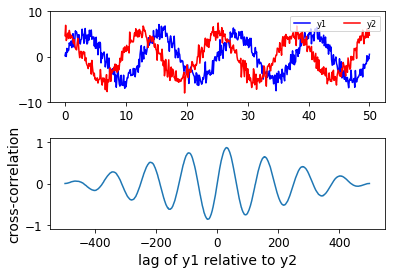

In [42]:
npts = 500
x = np.linspace(0, 50, npts)
y1 = 5 * np.sin(x/2) + np.random.randn(npts)
y2 = 5 * np.cos(x/2) + np.random.randn(npts)

lags = np.arange(-npts + 1, npts)
ccov = np.correlate(y1 - y1.mean(), y2 - y2.mean(), mode='full')
ccor = ccov / (npts * y1.std() * y2.std())

fig, axs = plt.subplots(nrows=2)
fig.subplots_adjust(hspace=0.4)
ax = axs[0]
ax.plot(x, y1, 'b', label='y1')
ax.plot(x, y2, 'r', label='y2')
ax.set_ylim(-10, 10)
ax.legend(loc='upper right', fontsize='small', ncol=2)

ax = axs[1]
ax.plot(lags, ccor)
ax.set_ylim(-1.1, 1.1)
ax.set_ylabel('cross-correlation')
ax.set_xlabel('lag of y1 relative to y2')

maxlag = lags[np.argmax(ccor)]
print("max correlation is at lag %d" % maxlag)

standard deviations:  0.9853933174990485 0.7835952750445907


Text(0,0.5,'autocorrelation')

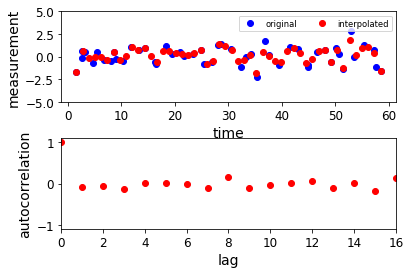

In [43]:
nt = 50
t = 2 * np.random.rand(50).cumsum()
x = np.random.randn(nt)

# Make a uniform grid, with the same number of points:
tnew = np.linspace(t.min(), t.max(), nt)
xnew = np.interp(tnew, t, x)

print("standard deviations: ", x.std(), xnew.std())

fig, (ax0, ax1) = plt.subplots(2)
fig.subplots_adjust(hspace=0.4)
ax0.plot(t, x, 'bo', label='original') 
ax0.plot(tnew, xnew, 'ro', label='interpolated')
ax0.set_xlabel('time')
ax0.set_ylabel('measurement')
ax0.legend(loc='upper right', ncol=2, fontsize='small')
ax0.set_ylim(-5, 5)

lags, auto_x = autocorr(xnew)
ax1.plot(lags, auto_x, 'ro')

for ax in (ax0, ax1):
    ax.locator_params(axis='y', nbins=4)

ax1.set_xlim(0, nt//3) # To see the smaller lags better.
ax1.set_ylim(-1.1, 1.1)
ax1.set_xlabel('lag')
ax1.set_ylabel('autocorrelation')

Text(0,0.5,'ETH % Return')

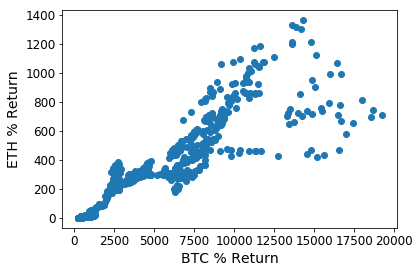

In [44]:
plt.scatter(combined_df['BTC'],combined_df['ETH'])
plt.xlabel('BTC % Return')
plt.ylabel('ETH % Return')

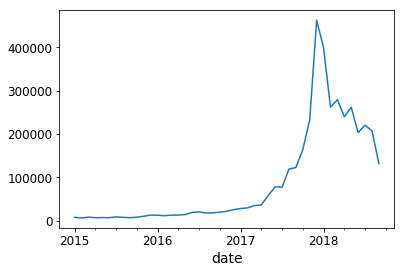

In [45]:
monthly=combined_df['BTC'].resample('M').sum()
monthly.plot( )

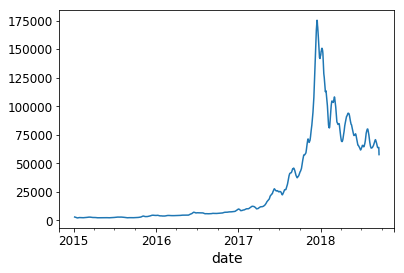

In [46]:
daily=combined_df['BTC'].resample('D').sum()
daily.rolling(10, center=True).sum().plot( )

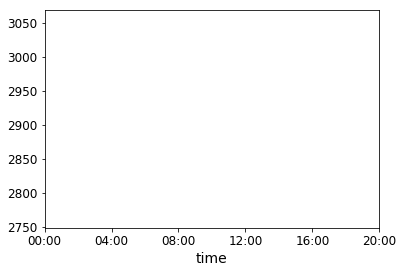

In [47]:
'''hourly time stamp'''

by_time=combined_df['BTC'].groupby(combined_df['BTC'].index.time).mean()
hourly_ticks= 4 * 60 * 60 * np.arange(6)
by_time.plot(xticks=hourly_ticks, style=[':','--','-'])

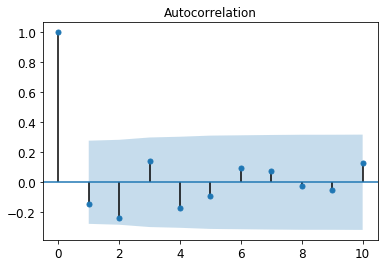

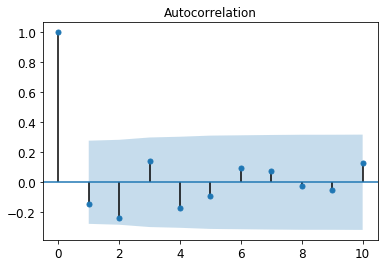

In [48]:
plot_acf(x, lags= 10, alpha=0.05)

#Blue area: confidence interval of ACF


#alpha sets the width of the confidence intrerval, eg: alpha=0.05 means 5% chance that if true autocorrelation is zero, it will fall outside blue band

In [49]:
#Numerical values of ACF

print(acf(x))

[ 1.         -0.14718979 -0.24127692  0.14094028 -0.17297584 -0.09227395
  0.09359303  0.07809777 -0.02181242 -0.05481036  0.12527623 -0.21063189
 -0.09495894  0.27081391 -0.17899198  0.13322443 -0.04243494 -0.22359083
  0.05229857  0.01864324  0.04291744  0.05587558  0.05009636  0.11456783
 -0.19604173 -0.17192307  0.13584661  0.01046889  0.03833447  0.0031667
  0.07555535 -0.07370783 -0.05473734  0.1319693  -0.00954064 -0.05713603
  0.07722473 -0.0636542  -0.07707722  0.06220116 -0.04925826]


In [50]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

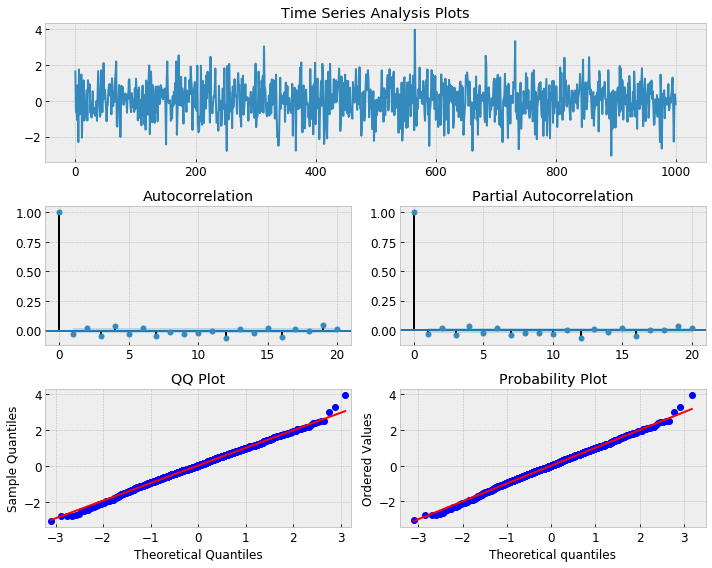

In [68]:
np.random.seed(1)

# plot of discrete white noise
randser = np.random.normal(size=1000)
tsplot(randser, lags=20)

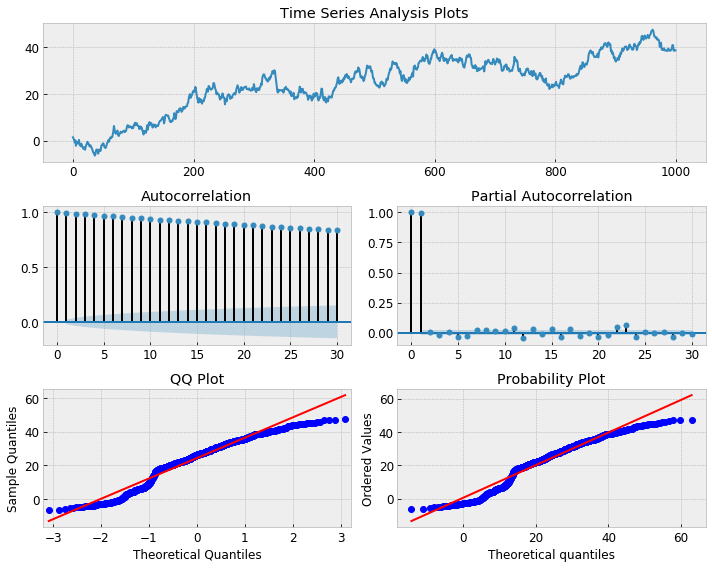

In [52]:
# Random Walk without a drift

np.random.seed(1)
n_samples = 1000

x = w = np.random.normal(size=n_samples)
for t in range(n_samples):
    x[t] = x[t-1] + w[t]

_ = tsplot(x, lags=30)

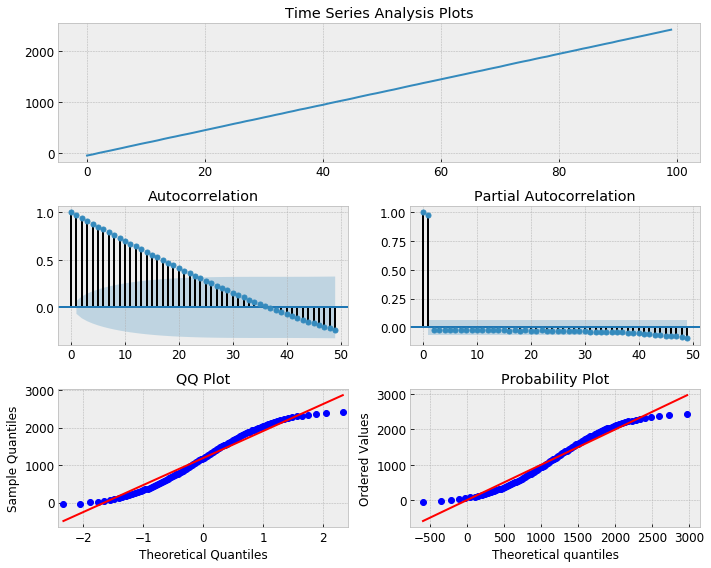

In [53]:
# simulate linear trend
# example Firm ABC sales are -$50 by default and +$25 at every time step

w = np.random.randn(100)
y = np.empty_like(w)

b0 = -50.
b1 = 25.
for t in range(len(w)):
    y[t] = b0 + b1*t + w[t]
    
_ = tsplot(y, lags=lags)  

In [54]:
altcoins = ['ETH','LTC','XRP','ETC','STR','DASH','SC','XMR','XEM', 'ZEC']

altcoin_data = {}
for altcoin in altcoins:
    coinpair = 'BTC_{}'.format(altcoin)
    crypto_price_df = get_crypto_data(coinpair)
    altcoin_data[altcoin] = crypto_price_df
    
for altcoin in altcoin_data.keys():
    altcoin_data[altcoin]['price_usd'] =  altcoin_data[altcoin]['weightedAverage'] * btc_usd_datasets['avg_btc_price_usd']
    
combined_df = merge_dfs_on_column(list(altcoin_data.values()), list(altcoin_data.keys()), 'price_usd')

combined_df['BTC'] = btc_usd_datasets['avg_btc_price_usd']

Loaded https://bitcoinchain.com/markets/btcusd-okcoin from cache
Loaded https://bitcoinchain.com/markets/btcusd-okcoin from cache
Loaded https://bitcoinchain.com/markets/btcusd-okcoin from cache
Loaded https://bitcoinchain.com/markets/btcusd-okcoin from cache
Loaded https://bitcoinchain.com/markets/btcusd-okcoin from cache
Loaded https://bitcoinchain.com/markets/btcusd-okcoin from cache
Loaded https://bitcoinchain.com/markets/btcusd-okcoin from cache
Loaded https://bitcoinchain.com/markets/btcusd-okcoin from cache
Loaded https://bitcoinchain.com/markets/btcusd-okcoin from cache
Loaded https://bitcoinchain.com/markets/btcusd-okcoin from cache


In [55]:
y = combined_df['BTC'].resample('MS').mean()

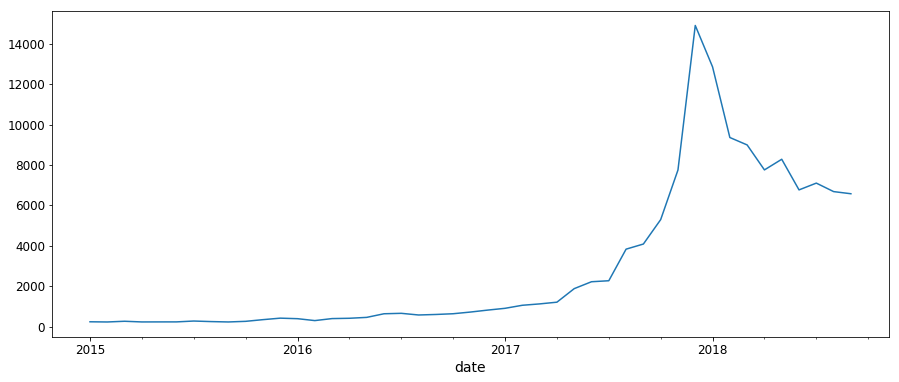

In [56]:
y.plot(figsize=(15, 6))
plt.show()

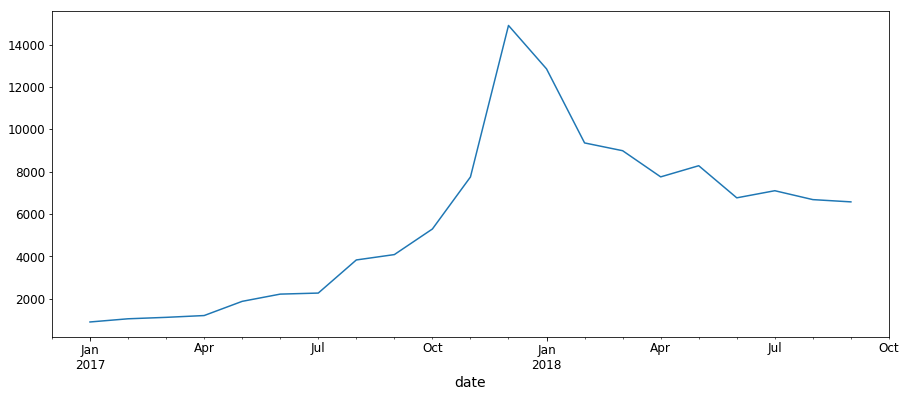

In [57]:
y['2017':].plot(figsize=(15, 6))
plt.show()

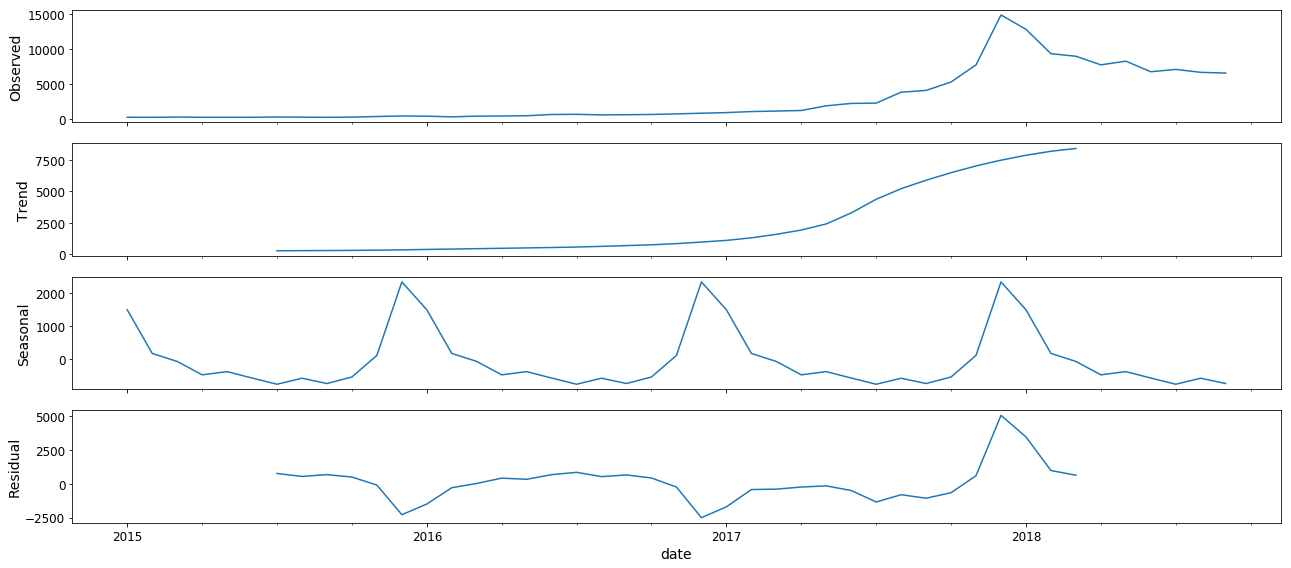

In [58]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

In [59]:
'''Time series forecasting with ARIMA (Autoregressive Integrated Moving Average)'''

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [60]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:872.707688569202
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1263.709649947687
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:634.4635615308989
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:640.408392241142
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1212.251256935578
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:421.29675815344257
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:806.3421343776954
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2639.0374967200673
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:595.4471344487545
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:612.1943275462337
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2330.994497818024
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:403.17485253830654
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:746.2620407775171
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1086.1752874664721
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:550.4075167755319
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:567.2503966520505
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1171.5998542326477
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:364.8870247746252
ARIMA(0

In [61]:
'''The above output suggests that SARIMAX(1, 1, 1)x(1, 1, 0, 12) yields the lowest AIC value of:349.32'''

'''Therefore we should consider this to be optimal option.'''

#Fitting the ARIMA model

mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7004      0.162     -4.323      0.000      -1.018      -0.383
ma.L1          1.1363      0.087     13.047      0.000       0.966       1.307
ar.S.L12      -1.4478      5.293     -0.274      0.784     -11.821       8.926
sigma2      2.992e+06   2.68e-06   1.12e+12      0.000    2.99e+06    2.99e+06


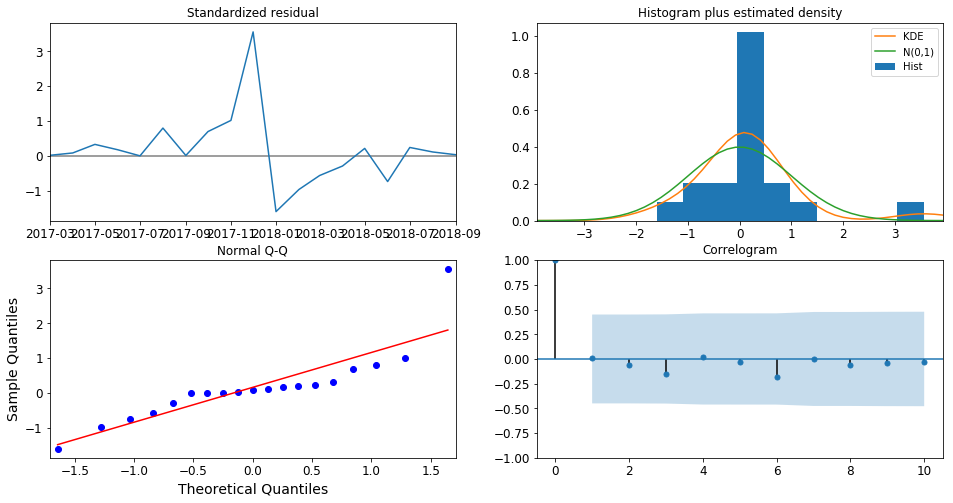

In [62]:
'''Fitting the ARIMA Model'''

'''Running model diagnostics to investigate any unusual behavior.'''

results.plot_diagnostics(figsize=(16, 8))
plt.show()

#Nearly normally distributed

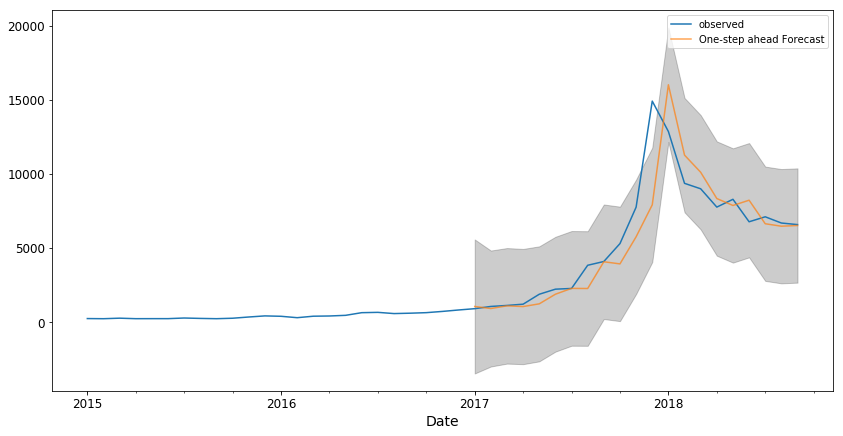

'The line plot is showing the observed values compared to the rolling forecast predictions.\n   Overall, our forecasts align with the true values very well.'

In [63]:
'''Validating forecasts'''

pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
plt.legend()
plt.show()

'''The line plot is showing the observed values compared to the rolling forecast predictions.
   Overall, our forecasts align with the true values very well.'''

In [64]:
''' Mean Squared Error of our forecasts'''

y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

'''The MSE is a measure of the quality of an estimator — it is always non-negative,
and the smaller the MSE, the closer we are to finding the line of best fit.'''

The Mean Squared Error of our forecasts is 3596819.56


'The MSE is a measure of the quality of an estimator\u200a—\u200ait is always non-negative,\nand the smaller the MSE, the closer we are to finding the line of best fit.'

In [65]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

'''Root Mean Square Error (RMSE) tells us that our model was able to forecast the average daily.'''

The Root Mean Squared Error of our forecasts is 1896.53


'Root Mean Square Error (RMSE) tells us that our model was able to forecast the average daily.'

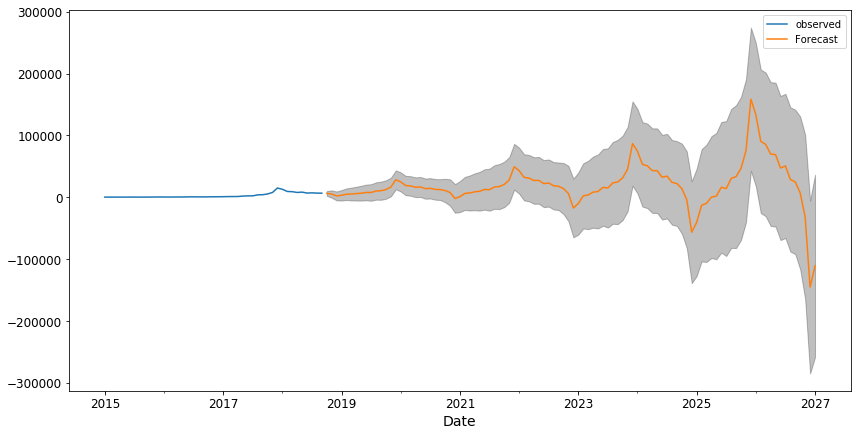

In [66]:
'''Producing and visualizing forecasts'''

pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')

plt.legend()
plt.show()

Text(0,0.5,'value')

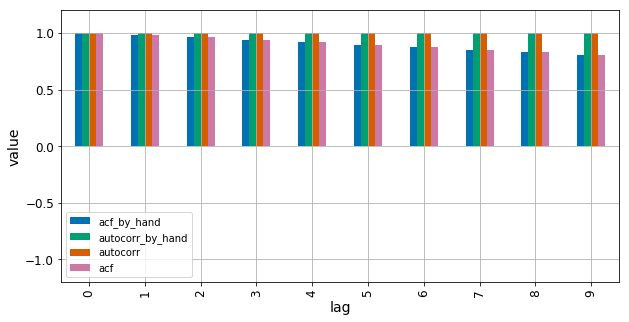

In [69]:
'''Some difference in pandas autocorr and statsmodel autocorr'''

plt.style.use("seaborn-colorblind")

def autocorr_by_hand(x, lag):
    # Slice the relevant subseries based on the lag
    y1 = x[:(len(x)-lag)]
    y2 = x[lag:]
    # Subtract the subseries means
    sum_product = np.sum((y1-np.mean(y1))*(y2-np.mean(y2)))
    # Normalize with the subseries stds
    return sum_product / ((len(x) - lag) * np.std(y1) * np.std(y2))

def acf_by_hand(x, lag):
    # Slice the relevant subseries based on the lag
    y1 = x[:(len(x)-lag)]
    y2 = x[lag:]
    # Subtract the mean of the whole series x to calculate Cov
    sum_product = np.sum((y1-np.mean(x))*(y2-np.mean(x)))
    # Normalize with var of whole series
    return sum_product / ((len(x) - lag) * np.var(x))

x = np.linspace(0,100,101)

results = {}
nlags=10
results["acf_by_hand"] = [acf_by_hand(x, lag) for lag in range(nlags)]
results["autocorr_by_hand"] = [autocorr_by_hand(x, lag) for lag in range(nlags)]
results["autocorr"] = [pd.Series(x).autocorr(lag) for lag in range(nlags)]
results["acf"] = acf(x, unbiased=True, nlags=nlags-1)

pd.DataFrame(results).plot(kind="bar", figsize=(10,5), grid=True)
plt.xlabel("lag")
plt.ylim([-1.2, 1.2])
plt.ylabel("value")

In [82]:
'''Last half year has indeed been very volatile and active period as we saw inflows of “new money” into the markets.
In order to do truly meaningful analysis, however, we need to work with percentage returns,
which we can easily achieve by running:'''

crypto_df_pct = combined_df.pct_change().dropna()

In [83]:
corr = crypto_df_pct.corr()

In [86]:
corr['LTC']['BTC']

0.6331219362252024

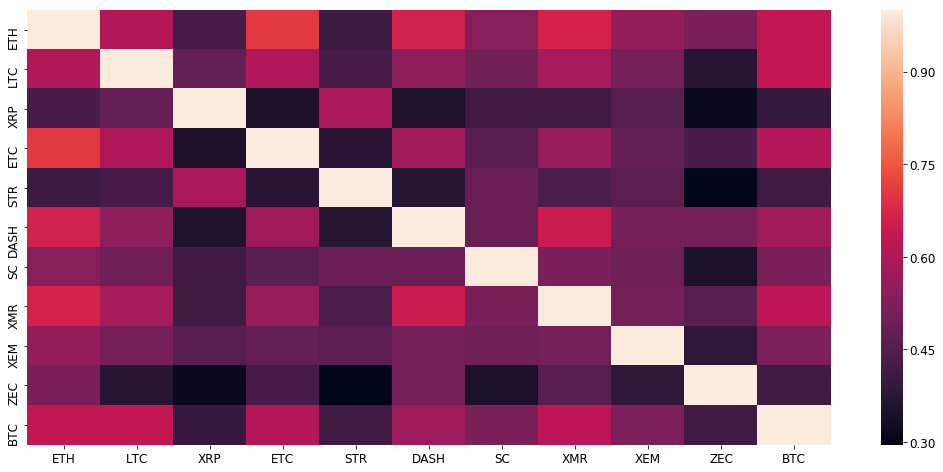

In [87]:
import seaborn as sns
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

''' the cryptocurrencies tend to mainly move together, at least against the dollar, as confirmed by all correlation values
being over 0'''

In [89]:
'''we may wish to analyse a relationship between two highly correlated currencies'''

corr['XMR']['DASH']

0.6478936243832524

Text(0,0.5,'USDT_XMR % Return')

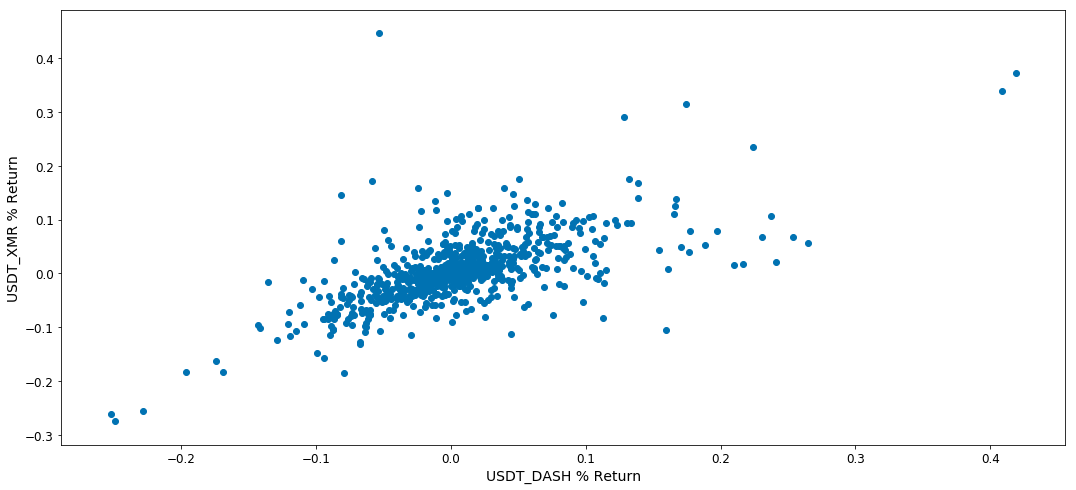

In [90]:
'''A scatter plot of respective returns'''

plt.scatter(crypto_df_pct['DASH'],crypto_df_pct['XMR'])
plt.xlabel('USDT_DASH % Return')
plt.ylabel('USDT_XMR % Return')

'''The relationship looks linear for most data points, but seems to be chaotic for extremely positive returns, 
exhibiting a “fan-like” relationship'''

In [93]:
import statsmodels.api as sm
model = sm.OLS(crypto_df_pct['XMR'],
               crypto_df_pct['DASH']).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    XMR   R-squared:                       0.424
Model:                            OLS   Adj. R-squared:                  0.423
Method:                 Least Squares   F-statistic:                     509.5
Date:                Mon, 12 Nov 2018   Prob (F-statistic):           5.79e-85
Time:                        14:46:17   Log-Likelihood:                 1086.7
No. Observations:                 693   AIC:                            -2171.
Df Residuals:                     692   BIC:                            -2167.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
DASH           0.6481      0.029     22.572      0.000       0.592       0.704
==============================================================================
Omnibus:                      306.332   Durbin-Watson:                   1.813
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5299.648
Skew:                           1.525   Prob(JB):                         0.00
Kurtosis:                      16.200   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0,0.5,'XMR % Return')

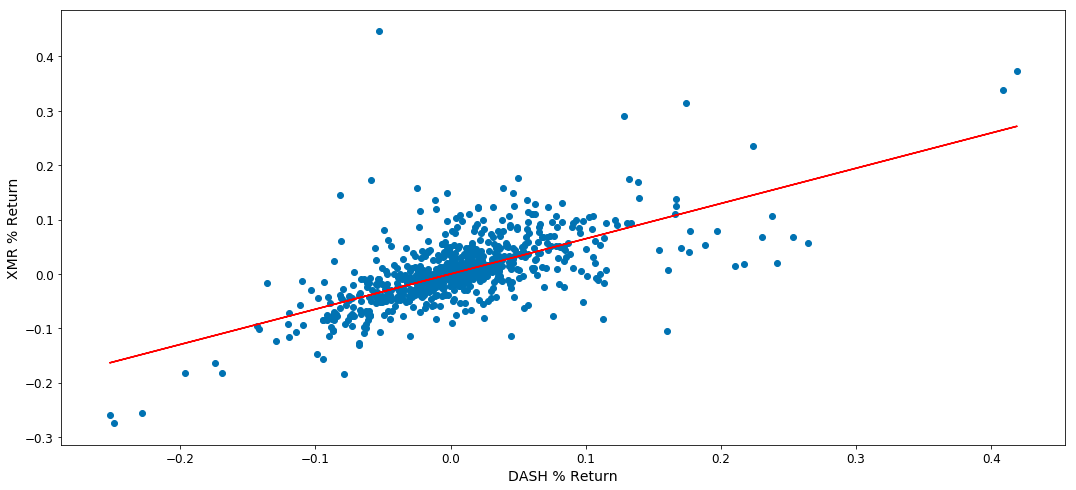

In [94]:
'''positive correlation between XMR AND DASH'''

line=[model.params[0]*i for i in crypto_df_pct['DASH'].values]
plt.plot(crypto_df_pct['DASH'], line, c = 'r')
plt.scatter(crypto_df_pct['DASH'],crypto_df_pct['XMR'])
plt.xlabel('DASH % Return')
plt.ylabel('XMR % Return')